# Прогнозирование временных рядов

In [39]:
import tensorflow as tf
from tensorflow import keras

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

## Наивное прогнозирование

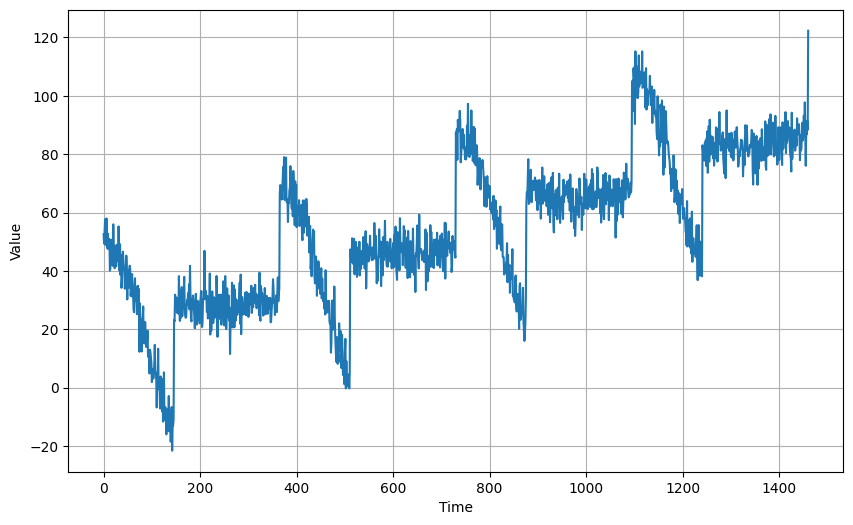

In [40]:
""" Генерируем данные с трендом, сезонностью и шумом """

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Произвольная формула для примера. Можете поэкспериментировать самостоятельно."""
    return np.where(season_time < 0.4,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Повторяет один и тот же шаблон каждый период."""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="float32")
baseline = 10
series = trend(time, 0.1)
baseline = 10
amplitude = 40
slope = 0.05
noise_level = 5

# Создаём последовательность
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Дополняем её шумом
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Теперь у нас есть готовая последовательность, поэтому разделим выборку, чтобы начать прогнозирование.

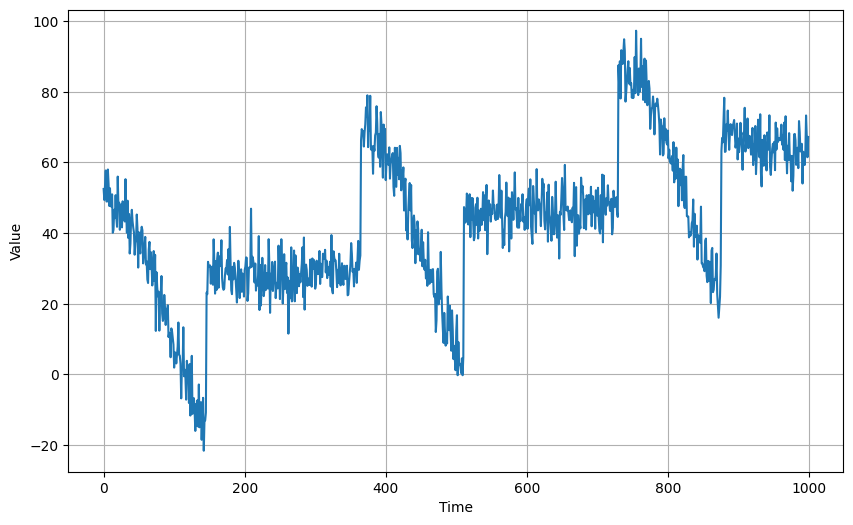

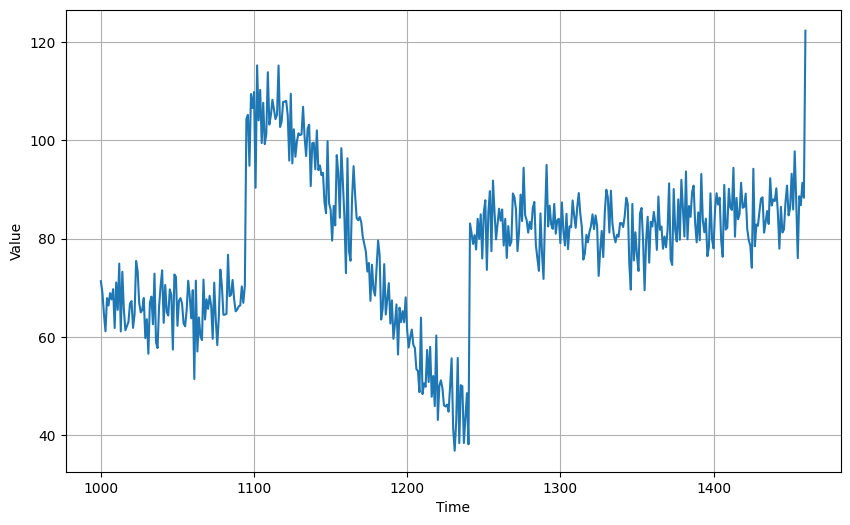

In [41]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

## Наивное прогнозирование

In [42]:
naive_forecast = series[split_time - 1:-1]

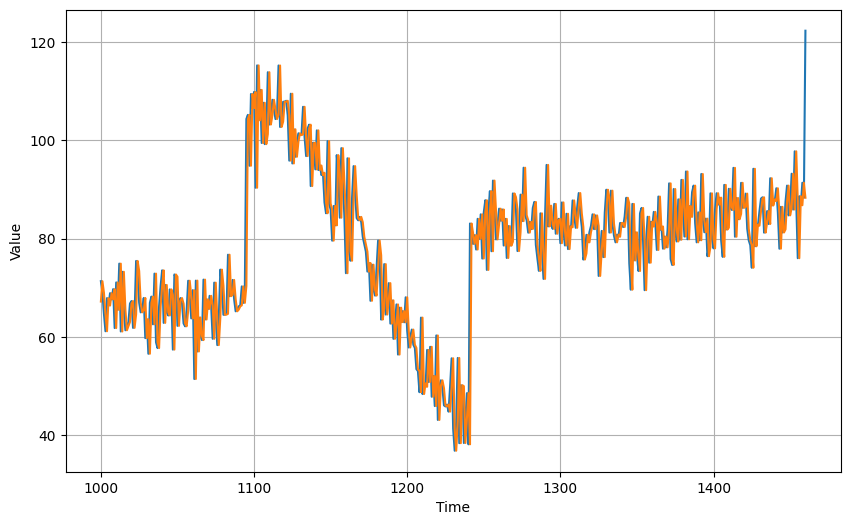

In [43]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

Увеличим начало проверочного периода:

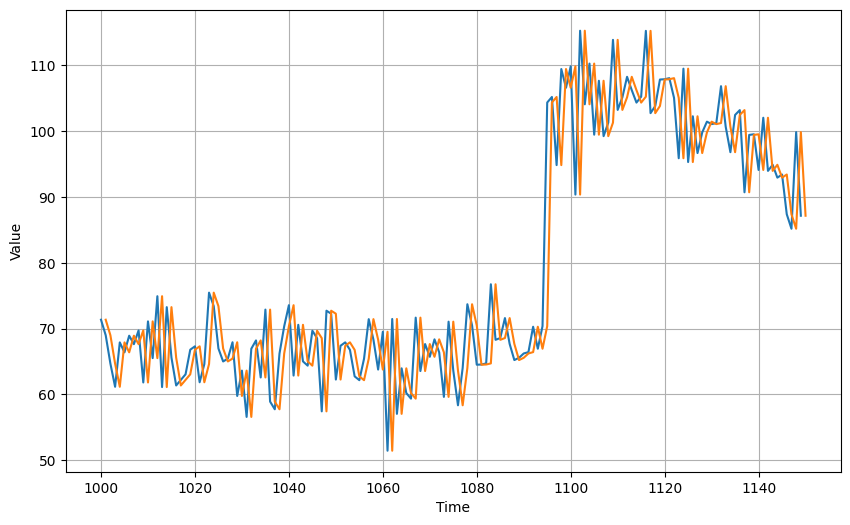

In [44]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

Замечаем, что наивный прогноз отстаёт на 1 шаг от исходной времнной последовательности.
Теперь вычислим MSE и MAE между прогнозом и данными валидацонной выборки.

In [45]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

AttributeError: module 'keras._tf_keras.keras.metrics' has no attribute 'mean_squared_error'

Итак, это наш базовый вариант. Попробуем простой метод скользящего среднего.

In [ ]:
def moving_average_forecast(series, window_size):
  """Предсказывает среднее нескольких последних значений.
     Если window_size=1, то это эквивалентно наивному предсказанию"""
  forecast = []
  for time in range(len(series) - window_size):
    forecast.append(series[time:time + window_size].mean())
  return np.array(forecast)

In [ ]:
moving_avg = moving_average_forecast(series, 30)[split_time - 30:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

Получилось даже хуже наивного прогноза! Дело в том, что скользящее среднее не учитывает тренд и сезонность, поэтому попробуем устранить их с помощью дифференцирования. Так как период сезонности 365 дней, мы вычтем значение в момент *t* – 365 из значения в момент *t*

In [ ]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
plt.show()

Итак, тренд и сезонность, похоже, исчезли, так что теперь мы можем использовать скользящее среднее:

In [ ]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Теперь давайте вернем тренд и сезонность, добавив прошлые значения из t – 365:

In [ ]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

Получилось лучше наивного прогноза. Однако прогнозы выглядят слишком случайными, потому что мы просто добавляем прошлые значения, которые были зашумлены. Давайте используем скользящее усреднение по прошлым значениям, чтобы убрать часть шума:

In [ ]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [ ]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())

Полученный результат теперь заметно лучше базового. Но чтобы добиться лучшего, потребуется более сложный подход, основанный на нейронных сетях, который рассмотрен далее.

## Прогнозирование временных рядов с помощью рекуррентных нейронных сетей

Набор метеорологических данных

Во всех примерах данного ipynb используются временные последовательности данных о погоде, записанные на гидрометеорологической станции в Институте биогеохимии им. Макса Планка.

В этот набор данных включены замеры 14 различных метеорологических показателей (таких, как температура воздуха, атмосферное давление, влажность), выполняющиеся каждые 10 минут начиная с 2003 года. Для экономии времени и используемой памяти будут использоваться данные, охватывающие период с 2009 по 2016 год

In [46]:
zip_path = tf.keras.utils.get_file(
    origin='https://storage.googleapis.com/tensorflow/tf-keras-datasets/jena_climate_2009_2016.csv.zip',
    fname='jena_climate_2009_2016.csv.zip',
    extract=True)
csv_path, _ = os.path.splitext(zip_path)

In [47]:
df = pd.read_csv(csv_path)

Посмотрим, что у нас имеется.

In [48]:
df.head()

,Date Time,p (mbar),T (degC),Tpot (K),Tdew (degC),rh (%),VPmax (mbar),VPact (mbar),VPdef (mbar),sh (g/kg),H2OC (mmol/mol),rho (g/m**3),wv (m/s),max. wv (m/s),wd (deg)
0,01.01.2009 00:10:00,996.52,-8.02,265.40,-8.90,93.3,3.33,3.11,0.22,1.94,3.12,1307.75,1.03,1.75,152.3
1,01.01.2009 00:20:00,996.57,-8.41,265.01,-9.28,93.4,3.23,3.02,0.21,1.89,3.03,1309.80,0.72,1.50,136.1
2,01.01.2009 00:30:00,996.53,-8.51,264.91,-9.31,93.9,3.21,3.01,0.20,1.88,3.02,1310.24,0.19,0.63,171.6
3,01.01.2009 00:40:00,996.51,-8.31,265.12,-9.07,94.2,3.26,3.07,0.19,1.92,3.08,1309.19,0.34,0.50,198.0
4,01.01.2009 00:50:00,996.51,-8.27,265.15,-9.04,94.1,3.27,3.08,0.19,1.92,3.09,1309.00,0.32,0.63,214.3


В том, что период записи наблюдения составляет 10 минут, можно убедиться по вышеприведённой таблице. Таким образом, в течение одного часа будет 6 наблюдений. В свою очередь за сутки накапливается 144 (6x24) наблюдения.

Допустим, необходимо cпрогнозировать температуру, которая будет через 6 часов в будущем. Этот прогноз делается на основе имеющихся данных за определённый период: например, за 5 дней наблюдений. Следовательно, для обучения модели необходимо создать временной интервал, содержащий последние 720 (5x144) наблюдений

Приведенная ниже функция возвращает вышеописанные временные интервалы для обучения модели. Аргумент history_size — это размер последнего временного интервала, target_size – аргумент, определяющий насколько далеко в будущее модель должна научиться прогнозировать. Другими словами, target_size – это целевой вектор, который необходимо спрогнозировать.

In [49]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Изменение размера данных с (history_size,) на (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

В обеих частях ноутбука первые 300 000 строк данных будут использоваться для обучения модели, оставшиеся – для её валидации (проверки). В этом случае объём обучающих данных составляет примерно 2100 дней.

In [50]:
TRAIN_SPLIT = 300000

Для обеспечения воспроизводимости результатов устанавливается функция seed.

In [51]:
tf.random.set_seed(13)

## Часть 1. Прогнозирование на основе одномерного временного ряда

Для начала извлечем только температуру из набора данных.

In [52]:
uni_data = df['T (degC)']
uni_data.index = df['Date Time']
uni_data.head()

,T (degC)
Date Time,
01.01.2009 00:10:00,-8.02
01.01.2009 00:20:00,-8.41
01.01.2009 00:30:00,-8.51
01.01.2009 00:40:00,-8.31
01.01.2009 00:50:00,-8.27


И посмотрим, как эти данные изменяются во времени.

array([<Axes: xlabel='Date Time'>], dtype=object)

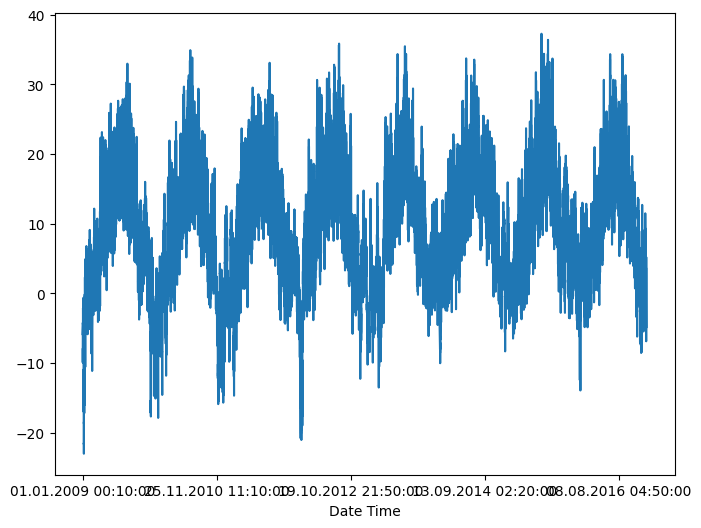

In [53]:
uni_data.plot(subplots=True)

In [54]:
uni_data = uni_data.values

Выполним стандартизацию данных.

In [55]:
uni_train_mean = uni_data[:TRAIN_SPLIT].mean()
uni_train_std = uni_data[:TRAIN_SPLIT].std()
uni_data = (uni_data-uni_train_mean)/uni_train_std

Далее подготовим данные для модели с одномерным входом. На вход в модель будут подаваться последние 20 зарегистрированных наблюдений за температурой, и модель необходимо обучить прогнозировать температуру на следующем шаге по времени.

In [56]:
univariate_past_history = 20
univariate_future_target = 0

x_train_uni, y_train_uni = univariate_data(uni_data, 0, TRAIN_SPLIT,
                                           univariate_past_history,
                                           univariate_future_target)
x_val_uni, y_val_uni = univariate_data(uni_data, TRAIN_SPLIT, None,
                                       univariate_past_history,
                                       univariate_future_target)

Результаты применения функции univariate_data.

In [57]:
print ('Временной интервал для наблюдений')
print (x_train_uni[0])
print ('\n Целевая температура для прогнозирования')
print (y_train_uni[0])

Временной интервал для наблюдений
[[-1.99766294]
 [-2.04281897]
 [-2.05439744]
 [-2.0312405 ]
 [-2.02660912]
 [-2.00113649]
 [-1.95134907]
 [-1.95134907]
 [-1.98492663]
 [-2.04513467]
 [-2.08334362]
 [-2.09723778]
 [-2.09376424]
 [-2.09144854]
 [-2.07176515]
 [-2.07176515]
 [-2.07639653]
 [-2.08913285]
 [-2.09260639]
 [-2.10418486]]

 Целевая температура для прогнозирования
-2.1041848598100876


*Примечание*
*Подготовка данных для модели с одномерным входом схематично изображена на  рисунке ниже (для удобства на этом и последующих рисунках данные представлены в «сыром» виде, до стандартизации, а также без признака ‘Date time’ в качестве индекса)*  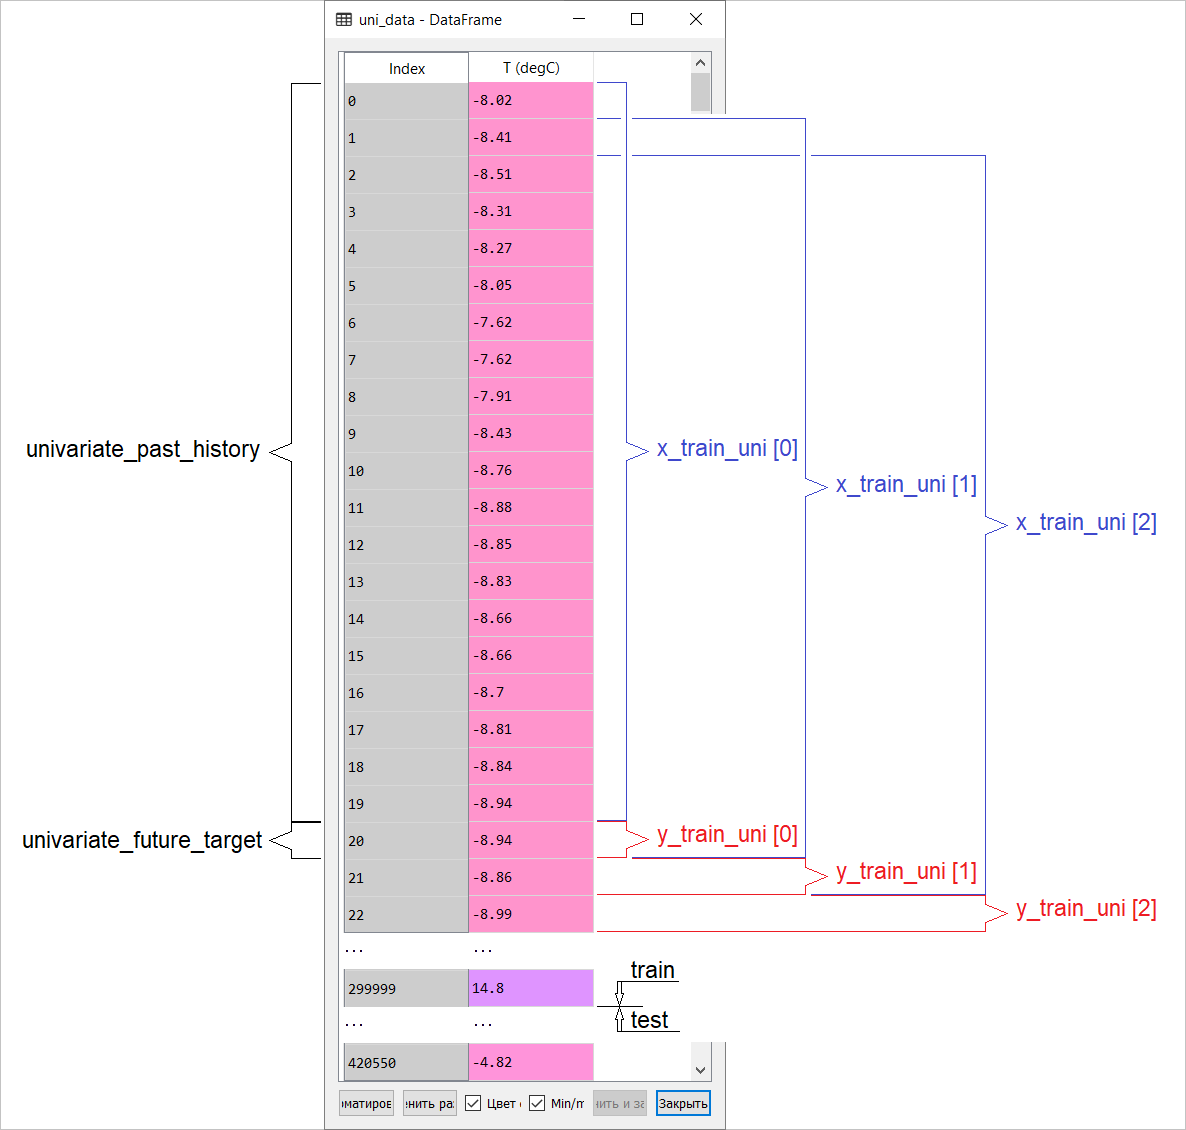

Теперь, когда данные соответствующим образом подготовлены, рассмотрим конкретный пример. Передаваемая в ИНС (искуственная нейронная сеть) информация на графике выделена синим цветом, а красным крестиком обозначено будущее значение, которое ИНС должна спрогнозировать.


In [58]:
def create_time_steps(length):
  return list(range(-length, 0))

In [59]:
def show_plot(plot_data, delta, title):
  labels = ['История', 'Истинное будущее значение', 'Прогноз модели']
  marker = ['.-', 'rx', 'go']
  time_steps = create_time_steps(plot_data[0].shape[0])
  if delta:
    future = delta
  else:
    future = 0

  plt.title(title)
  for i, x in enumerate(plot_data):
    if i:
      plt.plot(future, plot_data[i], marker[i], markersize=10,
               label=labels[i])
    else:
      plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
  plt.legend()
  plt.xlim([time_steps[0], (future+5)*2])
  plt.xlabel('Временной интервал')
  return plt

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

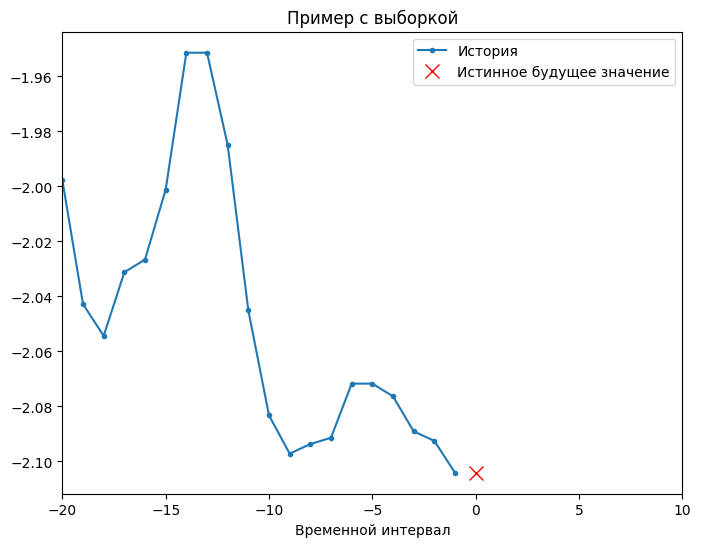

In [60]:
show_plot([x_train_uni[0], y_train_uni[0]], 0, 'Пример с выборкой')

#### Базовое решение (без привлечения машинного обучения)

Прежде чем приступить к обучению модели, установим простое базовое решение (baseline). Оно заключается в следующем: для заданного входного вектора метод базового решения «просматривает» всю историю и прогнозирует следующее значение как среднее из последних 20 наблюдений.

In [61]:
def baseline(history):
  return np.mean(history)

<module 'matplotlib.pyplot' from '/usr/local/lib/python3.10/dist-packages/matplotlib/pyplot.py'>

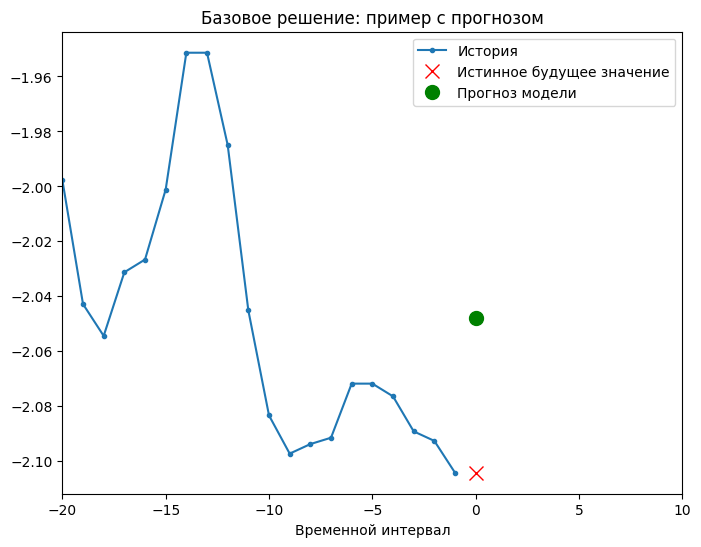

In [62]:
show_plot([x_train_uni[0], y_train_uni[0], baseline(x_train_uni[0])], 0,
           'Базовое решение: пример с прогнозом')

Посмотрим, сможем ли мы превзойти результат «усреднения», использую рекуррентную нейронную сеть.

#### Рекуррентная нейронная сеть



Рекуррентная нейронная сеть (РНС) — это тип ИНС, который хорошо подходит для решения задач, связанных с временными рядами. РНС шаг за шагом обрабатывает временную последовательность данных, перебирая её элементы и сохраняя внутреннее состояние, полученное при обработке предыдущих элементов.  В данном ноутбуке будет использоваться специализированный слой РНС, который называется «Долгая краткосрочная память» (англ. Long Short-Term Memory, LSTM).

Далее с помощью tf.data выполним перемешивание (shuffle), пакетирование (batch) и кэширование (cache) набора данных.

*Дополнение:*

*Подробнее про методы shuffle, batch и cache на странице [tensorflow](https://www.tensorflow.org/api_docs/python/tf/data/Dataset):*

In [63]:
BATCH_SIZE = 128
BUFFER_SIZE = 10000

train_univariate = tf.data.Dataset.from_tensor_slices((x_train_uni, y_train_uni))
train_univariate = train_univariate.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_univariate = tf.data.Dataset.from_tensor_slices((x_val_uni, y_val_uni))
val_univariate = val_univariate.batch(BATCH_SIZE).repeat()

Следующая визуализация должна помочь понять, как выглядят данные после пакетной обработки.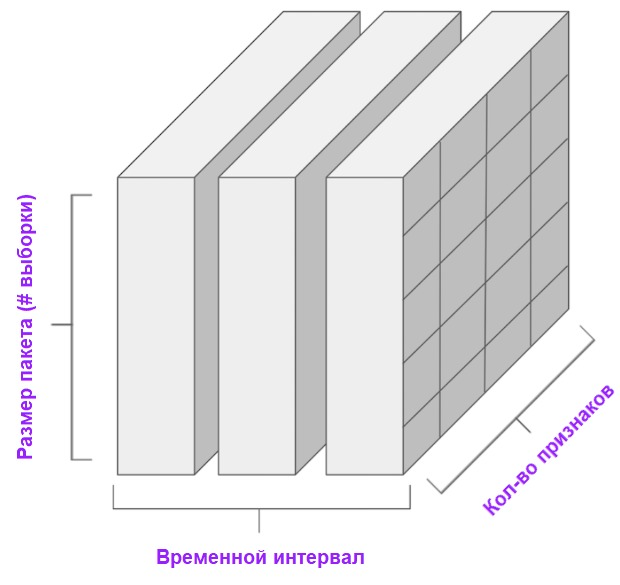

Видно, что LSTM требует определённой формы ввода данных, которые ему предоставляются.

In [64]:
simple_lstm_model = tf.keras.models.Sequential([
    tf.keras.layers.LSTM(8, input_shape=x_train_uni.shape[-2:]),
    tf.keras.layers.Dense(1)
])

simple_lstm_model.compile(optimizer='adam', loss='mae')

Проверим выход модели.

In [65]:
for x, y in val_univariate.take(1):
    print(simple_lstm_model.predict(x).shape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step  
(128, 1)


*Дополнение:*

*В общем плане РНС работают с последовательностями (sequences). Это означает, что подаваемые на вход модели данные должны иметь следующую форму:*

*[наблюдения, временной интервал, кол-во признаков]*
*Форма обучающих данных для модели с одномерным входом имеет следующий вид:*

*print(x_train_uni.shape)*
*(299980, 20, 1)*

Далее займёмся обучением модели. Из-за большого размера набора данных и в целях экономии времени каждая эпоха будет проходить только 200 шагов (steps_per_epoch=200) вместо полных данных обучения, как это обычно делается.

In [66]:
EVALUATION_INTERVAL = 200
EPOCHS = 10

simple_lstm_model.fit(train_univariate, epochs=EPOCHS,
                      steps_per_epoch=EVALUATION_INTERVAL,
                      validation_data=val_univariate, validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 4s 12ms/step - loss: 0.5324 - val_loss: 0.0498
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0753 - val_loss: 0.0254
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0452 - val_loss: 0.0204
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0397 - val_loss: 0.0246
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0283 - val_loss: 0.0296
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0312 - val_loss: 0.0304
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 9ms/step - loss: 0.0283 - val_loss: 0.0422
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - loss: 0.0292 - val_loss: 0.0322
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 3s 13ms/step - loss: 0.0161 - val_loss: 0.0202
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - loss: 0.0235 - val_loss: 0.0162


#### Прогнозирование с использованием простой модели LSTM

После выполнения подготовки простой LSTM-модели, выполним несколько прогнозов.

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


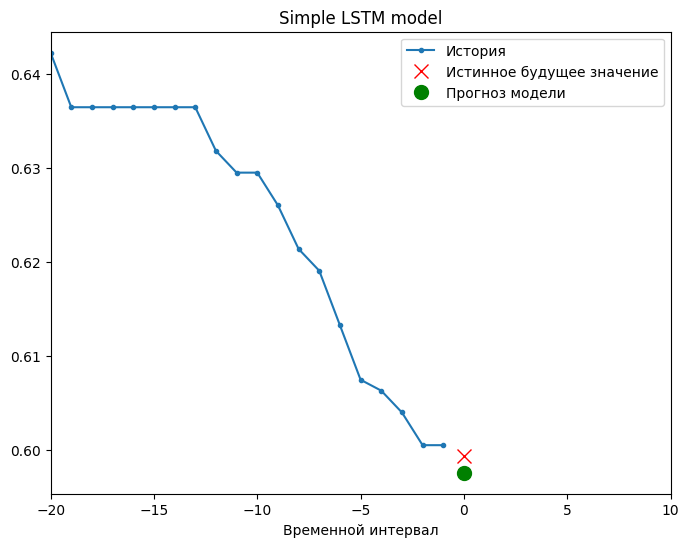

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


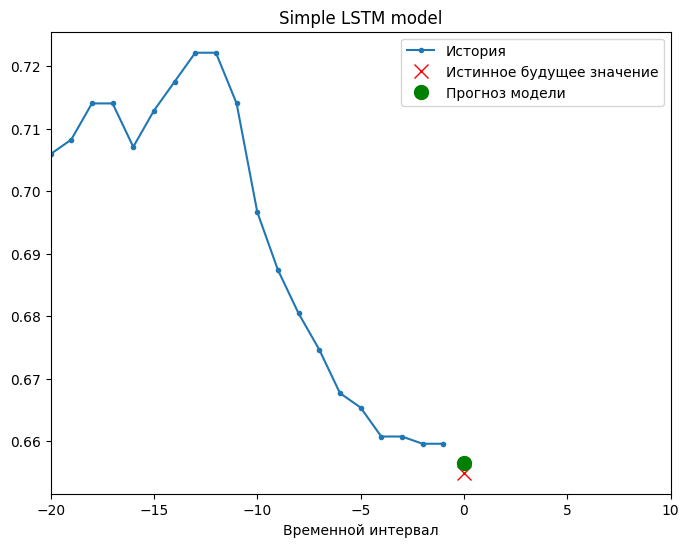

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


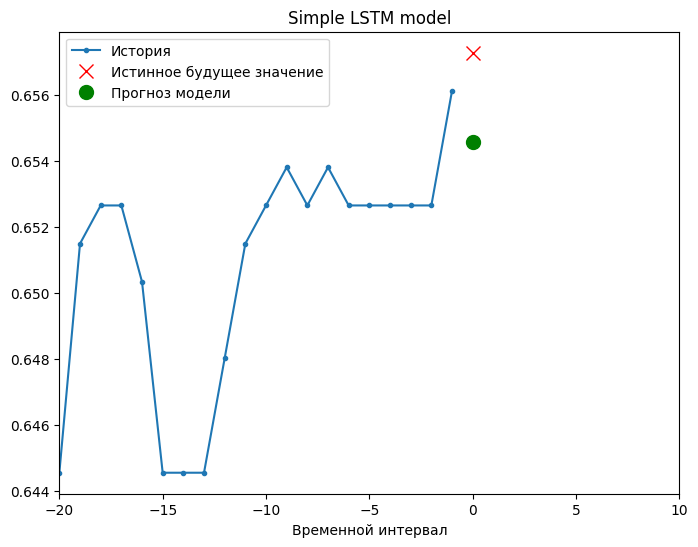

In [67]:
for x, y in val_univariate.take(3):
  plot = show_plot([x[0].numpy(), y[0].numpy(),
                    simple_lstm_model.predict(x)[0]], 0, 'Simple LSTM model')
  plot.show()

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step  


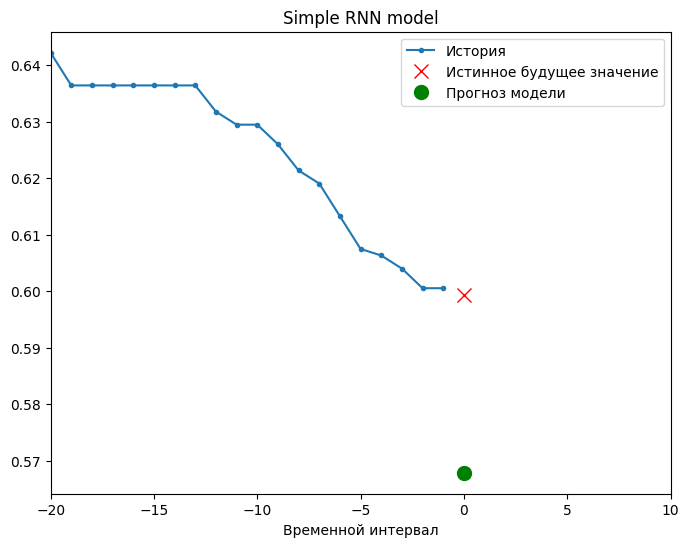

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


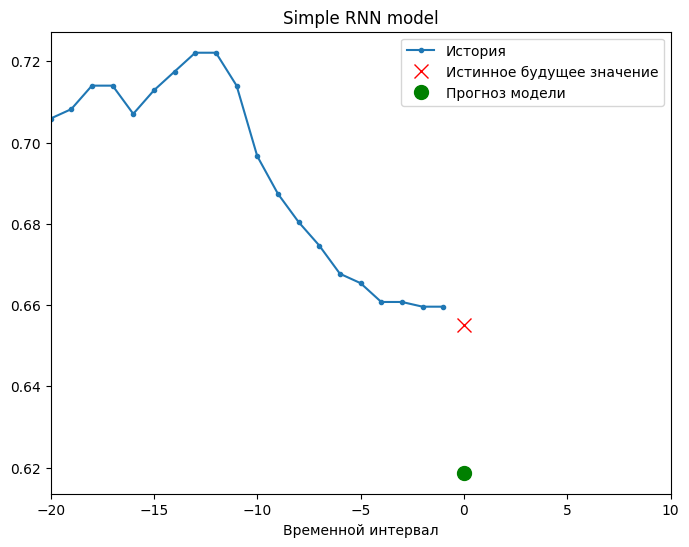

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step 


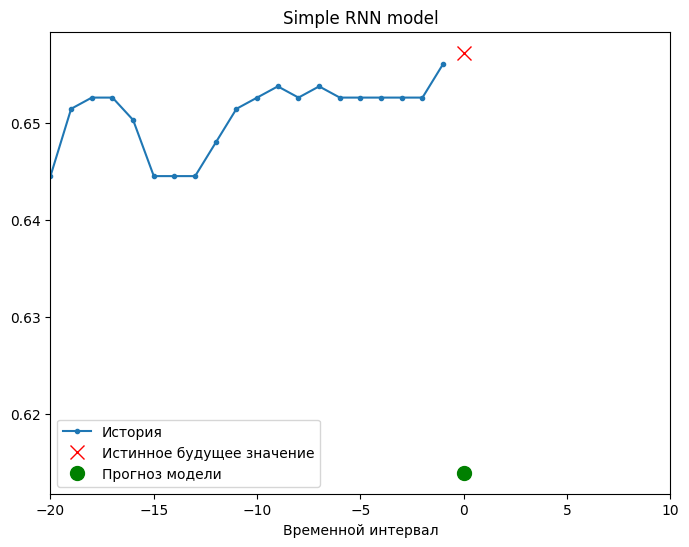

In [68]:
for x, y in val_univariate.take(3):
    plot = show_plot([x[0].numpy(), y[0].numpy(),
                      simple_rnn_model.predict(x)[0]], 0, 'Simple RNN model')
    plot.show()


In [ ]:
import matplotlib.pyplot as plt

plt.plot(y_test, label='Actual')
plt.plot(y_pred, label='Predicted')
plt.legend()
plt.show()


Выглядит лучше, чем базовый уровень.

Теперь, когда мы ознакомились с основами, давайте перейдем ко второй части, в которой описывается работа с многомерным временным рядом.

## Часть 2: Прогнозирование на основе многомерного временного ряда

Как было сказано, исходный набор данных содержит 14 различных метеорологических показателей. Для простоты и удобства во второй части рассматриваются только три из них — температура воздуха, атмосферное давление и плотность воздуха.

Чтобы использовать больше признаков, их названия нужно добавить в список feature_considered.

In [69]:
features_considered = ['p (mbar)', 'T (degC)', 'rho (g/m**3)']

In [70]:
features = df[features_considered]
features.index = df['Date Time']
features.head()

,p (mbar),T (degC),rho (g/m**3)
Date Time,,,
01.01.2009 00:10:00,996.52,-8.02,1307.75
01.01.2009 00:20:00,996.57,-8.41,1309.80
01.01.2009 00:30:00,996.53,-8.51,1310.24
01.01.2009 00:40:00,996.51,-8.31,1309.19
01.01.2009 00:50:00,996.51,-8.27,1309.00


Посмотрим, как эти показатели изменяются во времени.

array([<Axes: xlabel='Date Time'>, <Axes: xlabel='Date Time'>,
       <Axes: xlabel='Date Time'>], dtype=object)

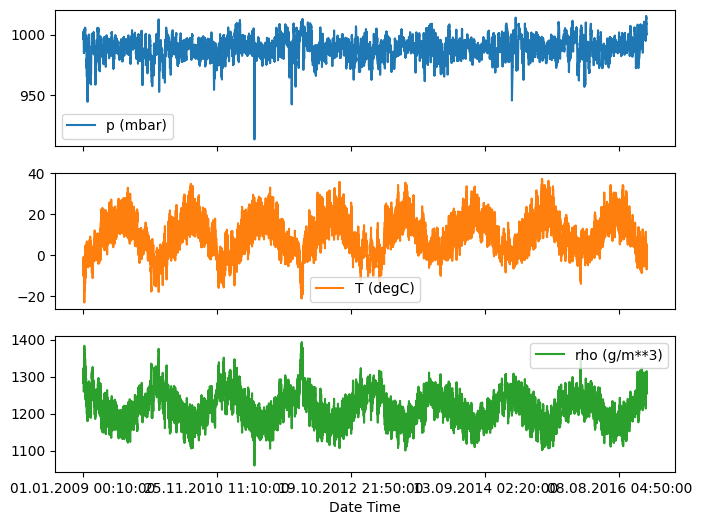

In [71]:
features.plot(subplots=True)

Как и ранее, первым шагом будет выполнение стандартизации набора данных с вычислением среднего значения и стандартного отклонения обучающих данных.

In [72]:
dataset = features.values
data_mean = dataset[:TRAIN_SPLIT].mean(axis=0)
data_std = dataset[:TRAIN_SPLIT].std(axis=0)
dataset = (dataset-data_mean)/data_std

Дополнение:

Далее в ноутбуке будет рассказано о точечном и интервальном прогнозировании.
Суть в следующем. Если вам нужно, чтобы модель прогнозировала одно значение в будущем (например, значение температуры через 12 часов) (one-step/single step model), то и обучить модель вы должны таким образом, чтобы она прогнозировала только одно значение в будущем. Если задача состоит в прогнозировании интервала значений в будущем (например, ежечасные значения температуры в течение следующих 12 часов) (multi-step model), то и модель должна быть обучена прогнозировать интервал значений в будущем.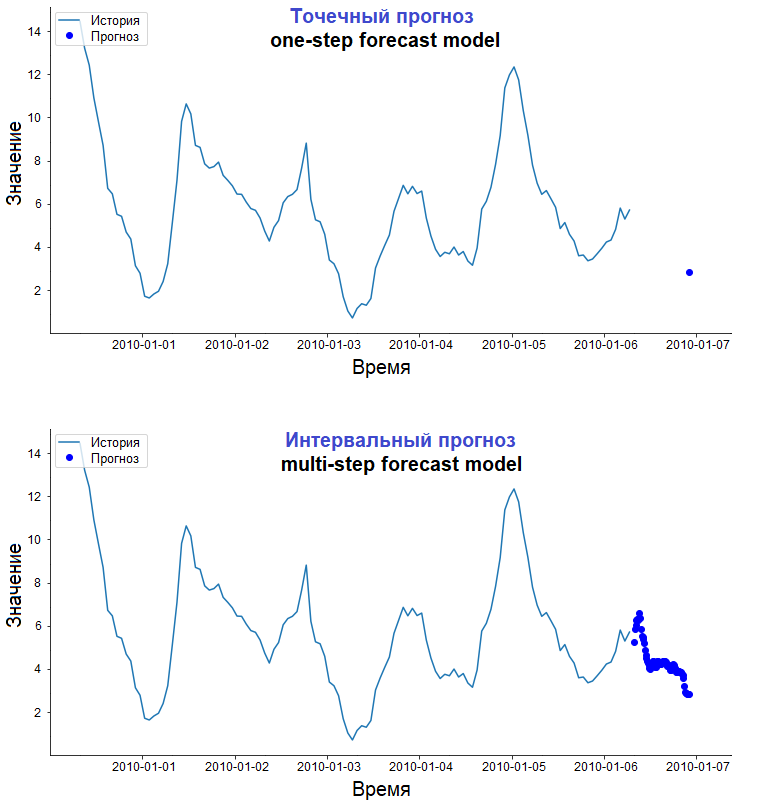

#### Точечное прогнозирование

В данном случае модель обучается прогнозированию одного значения в будущем на основе некой имеющейся истории.
Приведенная ниже функция выполняет ту же задачу организации временных интервалов лишь с тем отличием, что здесь она отбирает последние наблюдения на основе заданного размера шага.

In [73]:
def multivariate_data(dataset, target, start_index, end_index, history_size,
                      target_size, step, single_step=False):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i, step)
    data.append(dataset[indices])

    if single_step:
      labels.append(target[i+target_size])
    else:
      labels.append(target[i:i+target_size])

  return np.array(data), np.array(labels)

В данном руководстве ИНС оперирует данными за последние пять (5) дней, то есть 720 наблюдениями (6х24х5). Допустим, что отбор данных проводится не каждые 10 минут, а каждый час: в течение 60 минут резкие изменения не ожидаются. Следовательно, историю последних пяти дней составляют 120 наблюдений (720/6). Для модели, выполняющей точечное прогнозирование, целью является значение температуры через 12 часов в будущем. В этом случае целевой вектор будет составлять температура после 72 (12х6) наблюдений

In [74]:
past_history = 720
future_target = 72
STEP = 6

x_train_single, y_train_single = multivariate_data(dataset, dataset[:, 1], 0,
                                                   TRAIN_SPLIT, past_history,
                                                   future_target, STEP,
                                                   single_step=True)
x_val_single, y_val_single = multivariate_data(dataset, dataset[:, 1],
                                               TRAIN_SPLIT, None, past_history,
                                               future_target, STEP,
                                               single_step=True)

Проверим временной интервал.

In [75]:
print ('Single window of past history : {}'.format(x_train_single[0].shape))

Single window of past history : (120, 3)


In [76]:
train_data_single = tf.data.Dataset.from_tensor_slices((x_train_single, y_train_single))
train_data_single = train_data_single.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

val_data_single = tf.data.Dataset.from_tensor_slices((x_val_single, y_val_single))
val_data_single = val_data_single.batch(BATCH_SIZE).repeat()

In [77]:
single_step_model = tf.keras.models.Sequential()
single_step_model.add(tf.keras.layers.LSTM(32,
                                           input_shape=x_train_single.shape[-2:]))
single_step_model.add(tf.keras.layers.Dense(1))

single_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(), loss='mae')

Проверим нашу выборку и выведем кривые потерь на этапах обучения и проверки.

In [78]:
for x, y in val_data_single.take(1):
  print(single_step_model.predict(x).shape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step
(128, 1)


In [79]:
single_step_history = single_step_model.fit(train_data_single, epochs=EPOCHS,
                                            steps_per_epoch=EVALUATION_INTERVAL,
                                            validation_data=val_data_single,
                                            validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 21s 71ms/step - loss: 0.3741 - val_loss: 0.2941
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 0.2577 - val_loss: 0.2475
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 66ms/step - loss: 0.2687 - val_loss: 0.3244
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 0.2384 - val_loss: 0.2854
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 0.2694 - val_loss: 0.3558
Epoch 6/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 67ms/step - loss: 0.2555 - val_loss: 0.3482
Epoch 7/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 13s 63ms/step - loss: 0.2557 - val_loss: 0.2889
Epoch 8/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 15s 72ms/step - loss: 0.2433 - val_loss: 0.2469
Epoch 9/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 0.2106 - val_loss: 0.2328
Epoch 10/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 12s 62ms/step - loss: 0.2289 - val_loss: 0.3033


In [80]:
def plot_train_history(history, title):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(loss))

  plt.figure()

  plt.plot(epochs, loss, 'b', label='Потери на этапе обучения')
  plt.plot(epochs, val_loss, 'r', label='Потери на этапе проверки')
  plt.title(title)
  plt.legend()

  plt.show()

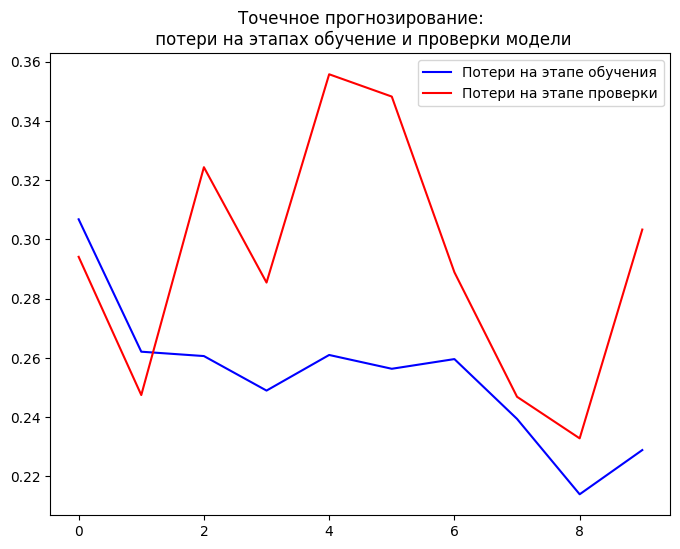

In [81]:
plot_train_history(single_step_history,
                   'Точечное прогнозирование:\n потери на этапах обучение и проверки модели')

*Дополнение*:

*Подготовка данных для модели с многомерным входом, выполняющей точечное прогнозирование, схематично изображена на следующем рисунке. Для удобства и более наглядного представления подготовки данных аргумент STEP равен 1. Обратите внимание, что в приводимых функциях-генераторах аргумент STEP предназначен только для формирования истории, а не для целевого вектора.*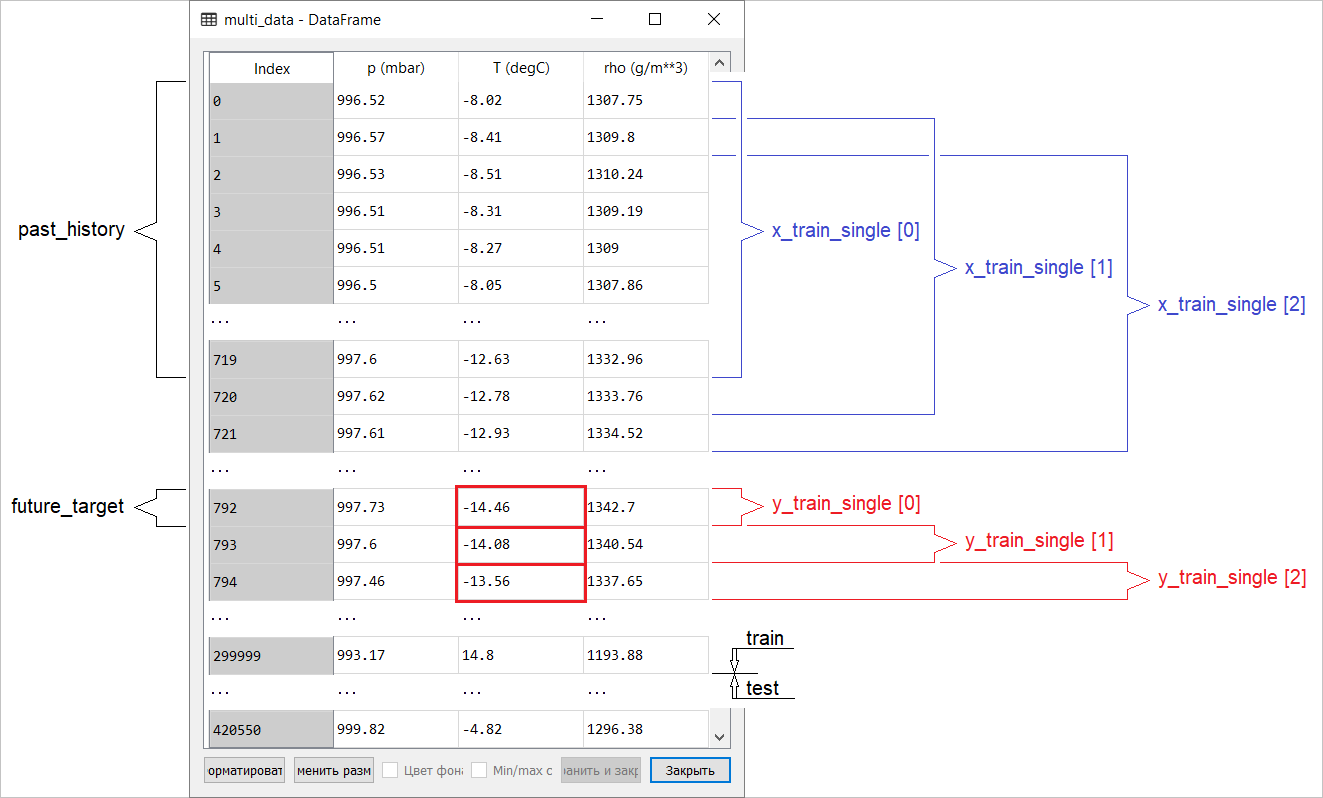

*В этом случае x_train_single имеет форму (299280, 720, 3).
При STEP=6, форма примет следующий вид: (299280, 120, 3) и скорость выполнения функции увеличиться в разы.*

#### Выполнение точечного прогноза

Теперь, когда модель обучена, выполним несколько пробных прогнозов. На вход модели подаётся история наблюдений 3-х признаков за последние пять дней, отобранных каждый час (временной интервал = 120). Так как наша цель заключается в прогнозе только температуры, то синим цветом на графике отображены прошлые значения температуры (история). Прогноз выполнен на полдня в будущее (отсюда и разрыв между историей и спрогнозированным значением).

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step


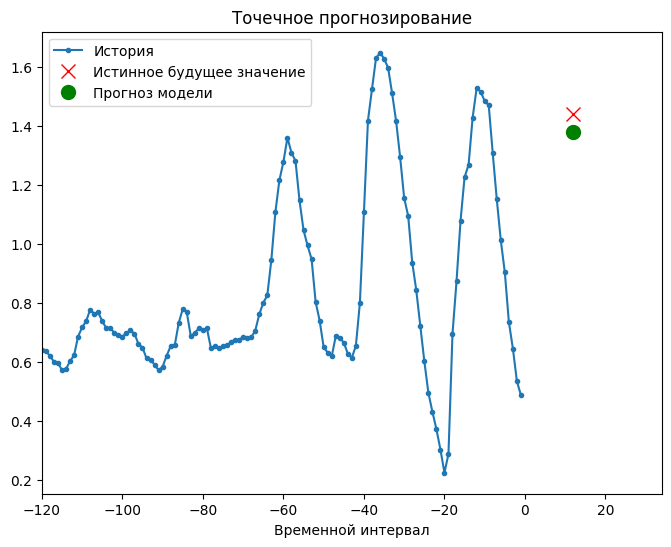

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 19ms/step


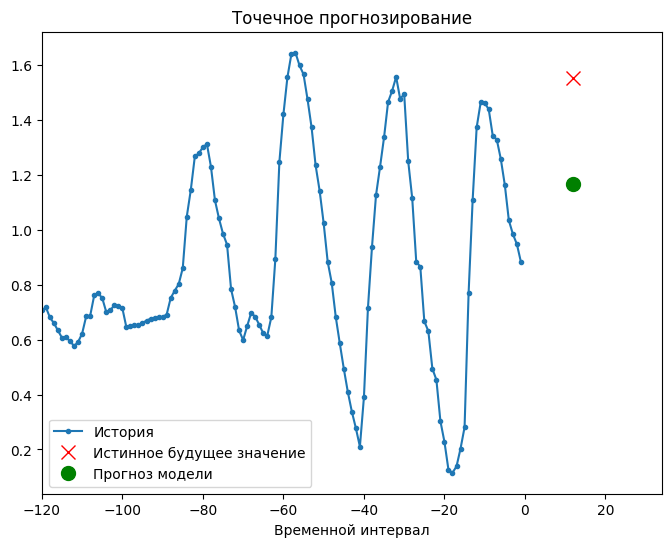

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


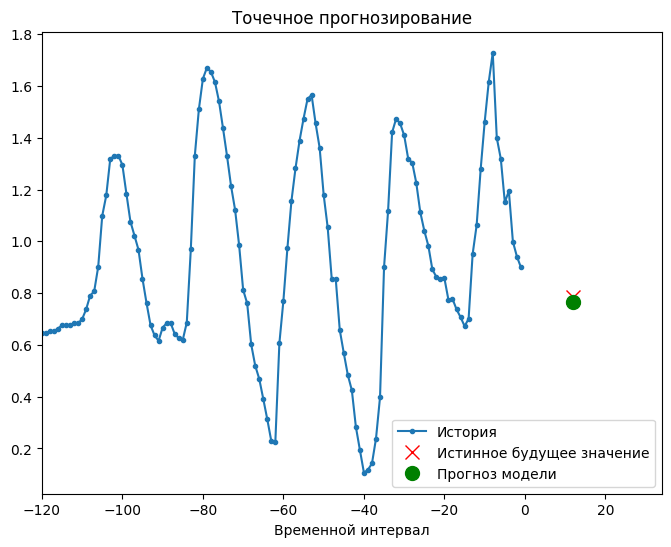

In [82]:
for x, y in val_data_single.take(3):
  plot = show_plot([x[0][:, 1].numpy(), y[0].numpy(),
                    single_step_model.predict(x)[0]], 12,
                   'Точечное прогнозирование')
  plot.show()

#### Интервальное прогнозирование

В этом случае на основе некой имеющейся истории модель обучается прогнозированию интервала будущих значений. Таким образом, в отличие модели, прогнозирующей только на одно значение в будущее, данная модель прогнозирует последовательность значений в будущем.

Допустим, как и в случае с моделью, выполняющей точечное прогнозирование, для модели, выполняющей интервальное прогнозирование, обучающими данными являются почасовые замеры последних пяти дней (720/6). Однако в данном случае модель необходимо обучить прогнозировать температуру на следующие 12 часов. Поскольку наблюдения регистрируются каждые 10 минут, выход (output) модели должен состоять из 72 прогнозов. Для выполнения этой задачи необходимо подготовить набор данных заново, но с другим целевым интервалом.

In [83]:
future_target = 72
x_train_multi, y_train_multi = multivariate_data(dataset, dataset[:, 1], 0,
                                                 TRAIN_SPLIT, past_history,
                                                 future_target, STEP)
x_val_multi, y_val_multi = multivariate_data(dataset, dataset[:, 1],
                                             TRAIN_SPLIT, None, past_history,
                                             future_target, STEP)

Проверим выборку

In [84]:
print ('Временной интервал для наблюдений : {}'.format(x_train_multi[0].shape))
print ('\n Целевая температура для прогнозирования : {}'.format(y_train_multi[0].shape))

Временной интервал для наблюдений : (120, 3)

 Целевая температура для прогнозирования : (72,)


In [85]:
BATCH_SIZE=256

with tf.device('/CPU:0'):
    train_data_multi = tf.data.Dataset.from_tensor_slices((x_train_multi, y_train_multi))
    train_data_multi = train_data_multi.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE).repeat()

    val_data_multi = tf.data.Dataset.from_tensor_slices((x_val_multi, y_val_multi))
    val_data_multi = val_data_multi.batch(BATCH_SIZE).repeat()

*Дополнение: отличие в формировании целевого вектора для «интервальной модели» от «точечной модели» видно на следующем рисунке.*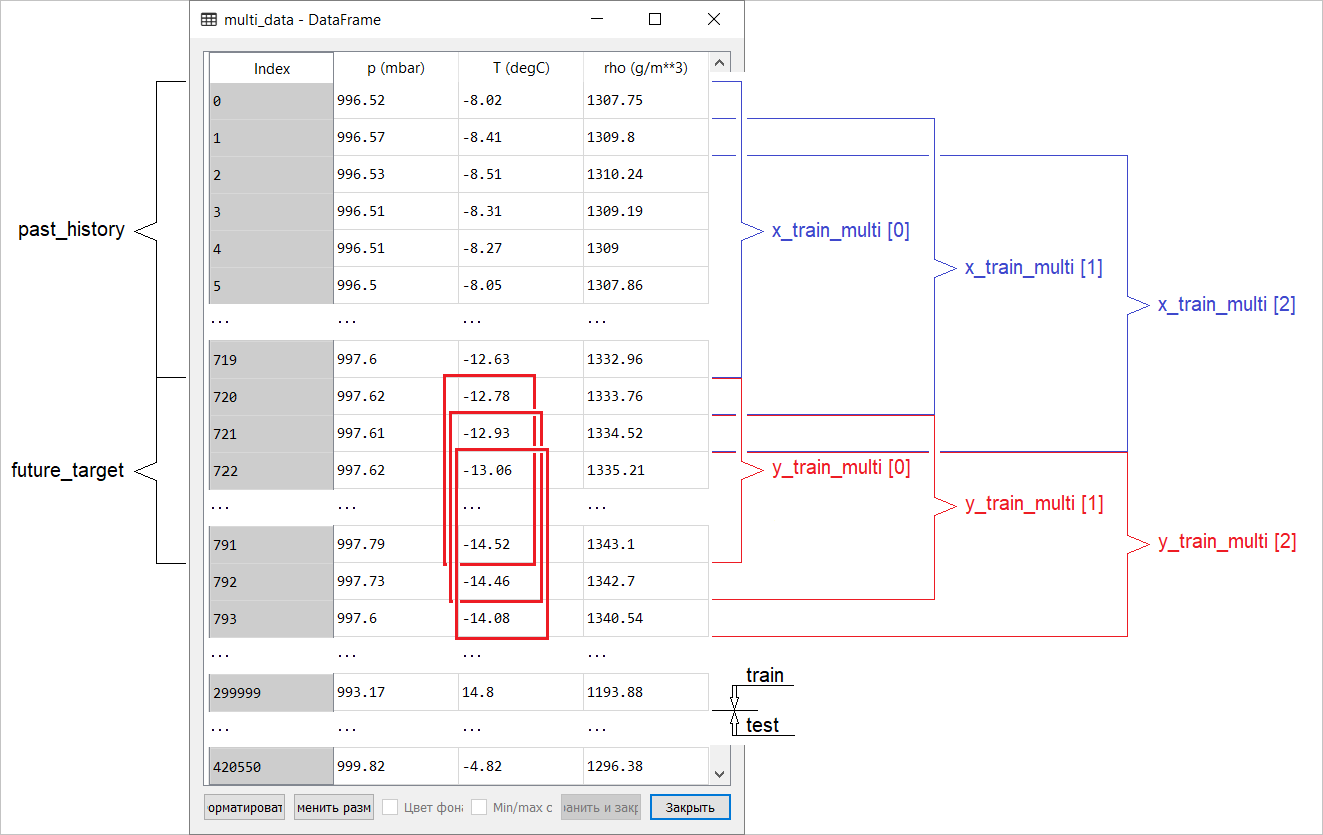

Подготовим визуализацию

In [86]:
def multi_step_plot(history, true_future, prediction):
  plt.figure(figsize=(12, 6))
  num_in = create_time_steps(len(history))
  num_out = len(true_future)

  plt.plot(num_in, np.array(history[:, 1]), label='История')
  plt.plot(np.arange(num_out)/STEP, np.array(true_future), 'bo',
           label='Истинное будущее значение')
  if prediction.any():
    plt.plot(np.arange(num_out)/STEP, np.array(prediction), 'ro',
             label='Прогноз модели')
  plt.legend(loc='upper left')
  plt.show()

На этом и последующих аналогичных графиках история и будущие данные ежечасные

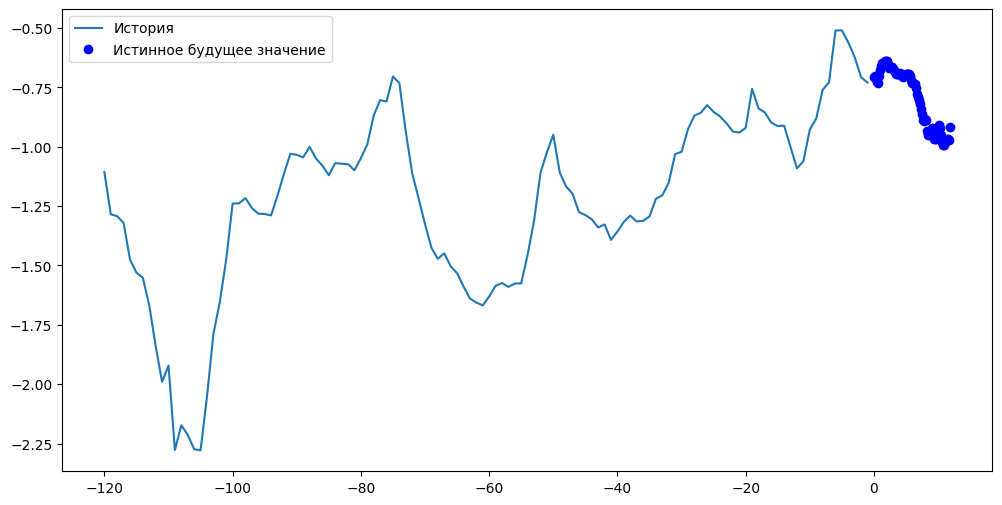

In [87]:
for x, y in train_data_multi.take(1):
  multi_step_plot(x[0], y[0], np.array([0]))

Так как эта задача немного сложнее, чем предыдущая, то модель будет состоять из двух слоёв LSTM. Наконец, поскольку выполняется 72 прогноза, выход слой насчитывает 72 нейрона.

In [88]:
multi_step_model = tf.keras.models.Sequential()
multi_step_model.add(tf.keras.layers.LSTM(32,
                                          return_sequences=True,
                                          input_shape=x_train_multi.shape[-2:]))
multi_step_model.add(tf.keras.layers.LSTM(16, activation='relu'))
multi_step_model.add(tf.keras.layers.Dense(72))

multi_step_model.compile(optimizer=tf.keras.optimizers.RMSprop(clipvalue=1.0), loss='mae')

Проверим нашу выборку и выведем кривые потерь на этапах обучения и проверки

In [89]:
with tf.device('/CPU:0'):
    for x, y in val_data_multi.take(1):
        print (multi_step_model.predict(x).shape)

8/8 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
(256, 72)


In [90]:
with tf.device('/CPU:0'):
    multi_step_history = multi_step_model.fit(train_data_multi, epochs=EPOCHS,
                                          steps_per_epoch=EVALUATION_INTERVAL,
                                          validation_data=val_data_multi,
                                          validation_steps=50)

Epoch 1/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 39s 179ms/step - loss: 0.6567 - val_loss: 0.2997
Epoch 2/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 33s 166ms/step - loss: 0.3328 - val_loss: 0.2637
Epoch 3/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 41s 205ms/step - loss: 0.3105 - val_loss: 0.3158
Epoch 4/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 35s 175ms/step - loss: 0.2589 - val_loss: 0.2423
Epoch 5/10
200/200 ━━━━━━━━━━━━━━━━━━━━ 35s 173ms/step - loss: 0.2033 - val_loss: 0.2202
Epoch 6/10
 51/200 ━━━━━━━━━━━━━━━━━━━━ 20s 136ms/step - loss: 0.2082

KeyboardInterrupt: 

In [ ]:
plot_train_history(multi_step_history, 'Интервальное прогнозирование\nпотери на этапах обучения и проверки модели')

#### Выполнение интервального прогноза

Итак, давайте выясним, насколько успешно обученная ИНС справляется с прогнозами будущих значений температуры.

In [ ]:
with tf.device('/CPU:0'):
    for x, y in val_data_multi.take(3):
        multi_step_plot(x[0], y[0], multi_step_model.predict(x)[0])

# Задание

1. Измените в примере LSTM на SimpleRNN и посмотрите как изменится точность обучения и прогноза.
2. Создайте модель машинного обучения для прогнозирования набора данных по варианту

Варианты
1. Производство электроэнергии
1. Месячное производство пива
1. Продажи шампуня за три года


#Задание 1

In [122]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.model_selection import train_test_split


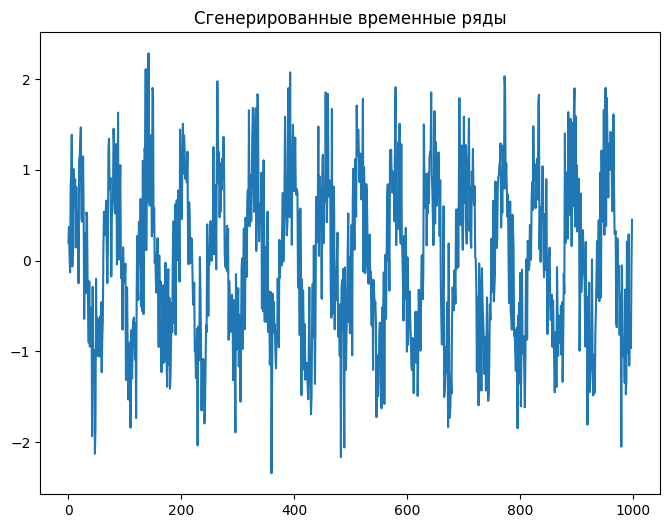

In [123]:
# Генерация данных
def generate_time_series(n_samples=1000, time_steps=10):
    x = np.linspace(0, 100, n_samples)
    y = np.sin(x) + np.random.normal(scale=0.5, size=x.shape)
    return y

data = generate_time_series()
plt.plot(data)
plt.title('Сгенерированные временные ряды')
plt.show()


In [124]:
def create_dataset(data, time_step=1):
    X, Y = [], []
    for i in range(len(data) - time_step - 1):
        a = data[i:(i + time_step)]
        X.append(a)
        Y.append(data[i + time_step])
    return np.array(X), np.array(Y)

# Параметры
time_steps = 10

# Подготовка данных
X, y = create_dataset(data, time_steps)
X = X.reshape(X.shape[0], X.shape[1], 1)

# Разбиение данных на обучающую и валидационную выборки
x_train, x_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


In [125]:
# Определение модели SimpleRNN
def create_simple_rnn_model(input_shape):
    model = tf.keras.models.Sequential([
        tf.keras.layers.SimpleRNN(8, input_shape=input_shape),  # Используем SimpleRNN
        tf.keras.layers.Dense(1)
    ])

    model.compile(optimizer='adam', loss='mae')
    return model

# Создаем модель
simple_rnn_model = create_simple_rnn_model(x_train.shape[1:])


In [126]:
# Обучение модели
EPOCHS = 50
BATCH_SIZE = 32

history = simple_rnn_model.fit(x_train, y_train,
                                epochs=EPOCHS,
                                batch_size=BATCH_SIZE,
                                validation_data=(x_val, y_val))


Epoch 1/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - loss: 0.5747 - val_loss: 0.4989
Epoch 2/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4788 - val_loss: 0.4683
Epoch 3/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4665 - val_loss: 0.4526
Epoch 4/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4613 - val_loss: 0.4457
Epoch 5/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4593 - val_loss: 0.4417
Epoch 6/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4582 - val_loss: 0.4406
Epoch 7/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4575 - val_loss: 0.4409
Epoch 8/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4570 - val_loss: 0.4405
Epoch 9/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4565 - val_loss: 0.4401
Epoch 10/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.4561 - val_loss: 0.4398
Epoch 11/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.4557 - val_loss: 0.4393
Epoch 12/50
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.4553 - val_l

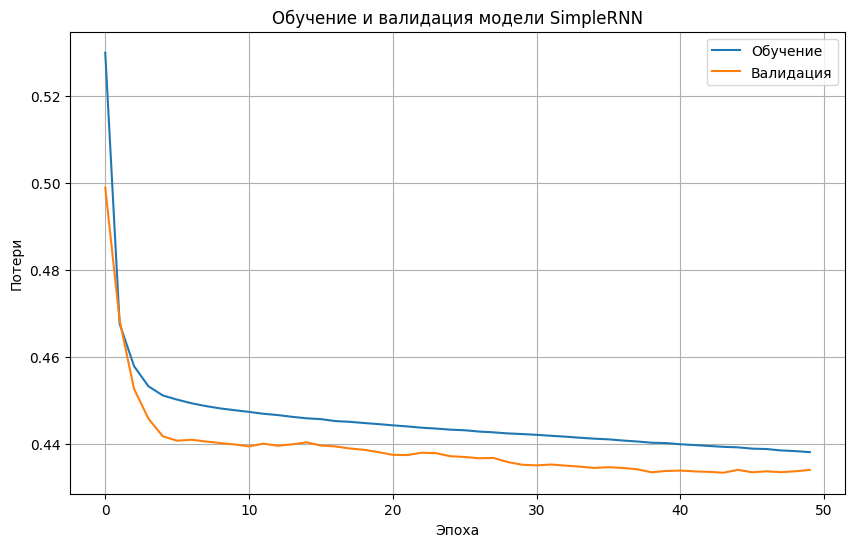

In [127]:
# Функция для визуализации потерь
def plot_train_history(history, title):
    plt.figure(figsize=(10, 6))
    plt.plot(history.history['loss'], label='Обучение')
    plt.plot(history.history['val_loss'], label='Валидация')
    plt.title(title)
    plt.ylabel('Потери')
    plt.xlabel('Эпоха')
    plt.legend()
    plt.grid(True)
    plt.show()

# Визуализируем результаты
plot_train_history(history, 'Обучение и валидация модели SimpleRNN')


7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step


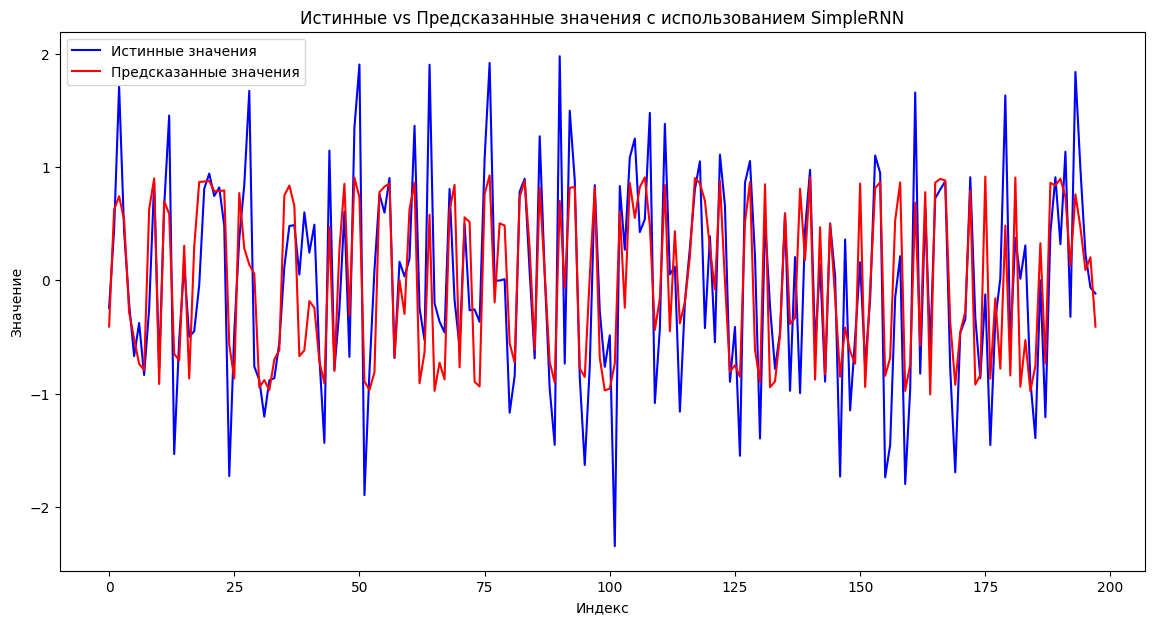

In [128]:
# Прогнозирование
predicted = simple_rnn_model.predict(x_val)

# Визуализируем предсказания
plt.figure(figsize=(14, 7))
plt.plot(y_val, label='Истинные значения', color='blue')
plt.plot(predicted, label='Предсказанные значения', color='red')
plt.title('Истинные vs Предсказанные значения с использованием SimpleRNN')
plt.xlabel('Индекс')
plt.ylabel('Значение')
plt.legend()
plt.show()


Когда мы рассматриваем результаты визуализации, такие как графики потерь (loss) и предсказаний, можно выделить несколько ключевых моментов для анализа. Давайте проанализируем оба графика:

### 1. График потерь (Loss)

На графике потерь наблюдаются две линии: линия для обучающей выборки и линия для валидационной выборки (validation).

- **Тенденция к уменьшению потерь:** Если обе линии (обучающая и валидационная) уменьшаются с увеличением числа эпох, это хороший признак того, что модель хорошо обучается и не переобучается (overfitting).
- **Разрыв между линиями:** Если валидационные потери начинают расти, в то время как обучающие потери продолжают уменьшаться, это может сигнализировать о том, что модель начинает переобучаться на обучающем наборе данных. В таком случае можно рассмотреть методы регуляризации, такие как dropout или уменьшение сложности модели.
- **Состояние на конце эпох:** Если обе линии стабилизировались и находятся на относительно низком уровне, это значит, что модель достигла определенного состояния, когда улучшения больше не наблюдаются. Можно попробовать изменить гиперпараметры (например, количество эпох или размер батча) для нового обучения.

### 2. График предсказаний

На графике предсказаний сравниваются истинные значения временного ряда (синим цветом) и предсказанные значения, сгенерированные моделью (красным цветом).

- **Совпадение линий:** Если красная линия (предсказания) близка к синей линии (истинные значения), это означает, что модель хорошо справляется с задачей прогнозирования и смогла уловить основные паттерны в данных.
- **Ошибки предсказаний:** Если предсказания значительно отклоняются от истинных значений (например, резкие пики или впадины), это может быть признаком того, что модель не полностью захватывает сложные зависимости в данных. Возможно, стоит рассмотреть более сложные модели или дополнительные функции (features).
- **Интервалы и время:** Обратите внимание на временные особенности зависимостей: если в предсказаниях наблюдаются регулярные ошибки, например, постоянные задержки, это можно улучшить, переработав подход к формированию временных окон или используя другие методы предобработки данных.

### Итог

На основе вышеприведенного анализа вы можете корректировать вашу модель, совершать попытки с различными архитектурами, гиперпараметрами и подходами к обработке данных для достижения лучших результатов в задаче прогнозирования временных рядов.

#Задание 2

In [92]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')


            Monthly beer production
Month                              
1956-01-01                     93.2
1956-02-01                     96.0
1956-03-01                     95.2
1956-04-01                     77.1
1956-05-01                     70.9


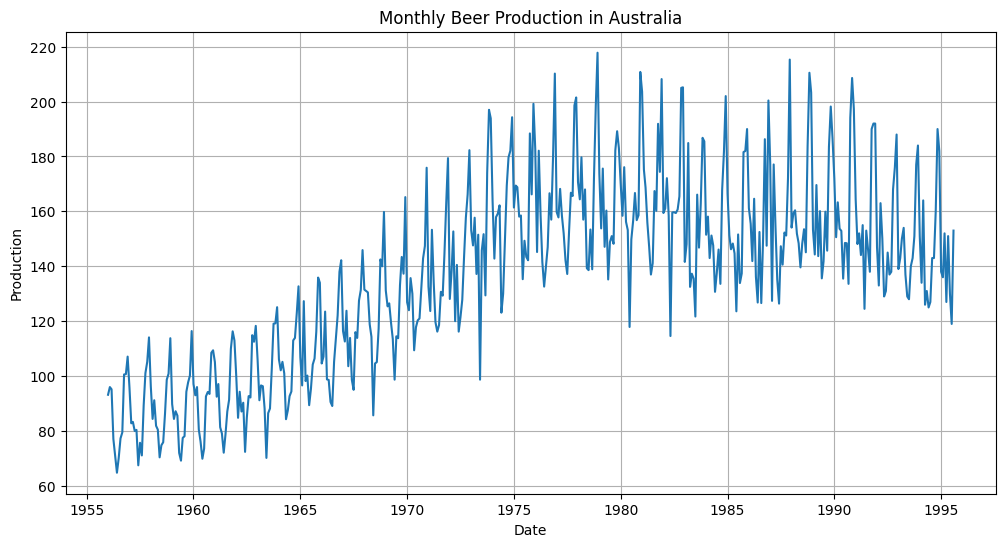

In [93]:
# Загрузить данные
data = pd.read_csv('monthly-beer-production-in-austr.csv')

# Преобразование столбца Month в формат даты
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data.set_index('Month', inplace=True)

# Посмотреть на данные
print(data.head())

# Визуализация исходных данных
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Monthly beer production'])
plt.title('Monthly Beer Production in Australia')
plt.xlabel('Date')
plt.ylabel('Production')
plt.grid(True)
plt.show()


In [94]:
# Создаем дополнительные признаки
data['Year'] = data.index.year
data['Month_num'] = data.index.month

# Создаем lag признаки
for lag in range(1, 13):  # Добавить лаги за последние 12 месяцев
    data[f'Lag_{lag}'] = data['Monthly beer production'].shift(lag)

# Убираем строки с пустыми значениями
data.dropna(inplace=True)

# Определяем признак X и целевую переменную y
X = data.drop(columns='Monthly beer production')
y = data['Monthly beer production']


In [95]:
# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (371, 14)
Testing data shape: (93, 14)


In [96]:
# Создание модели Random Forest
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

Mean Squared Error: 111.77408894623659


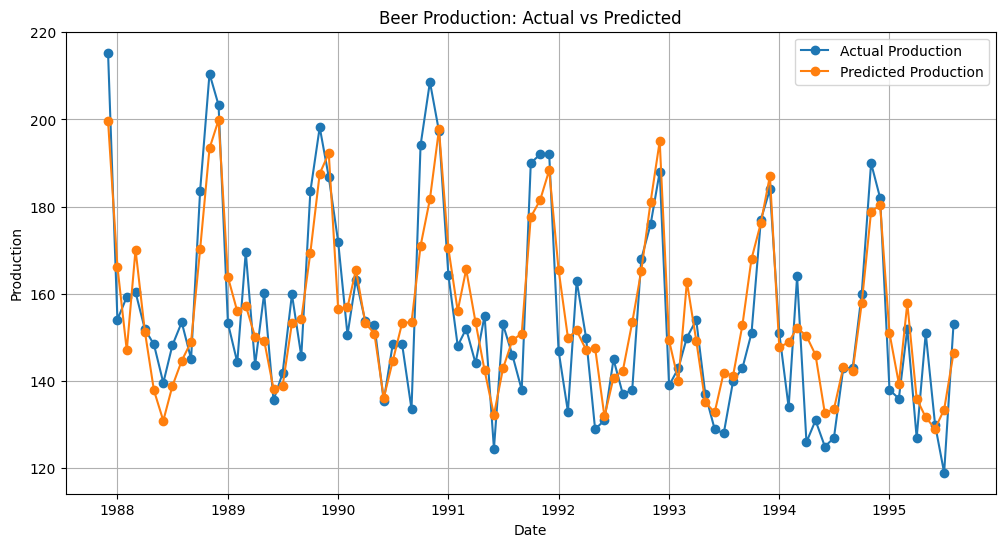

In [97]:
# Предсказания на тестовой выборке
y_pred = model.predict(X_test)

# Оценка производительности
mse = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse}')

# Визуализация предсказаний
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Production', marker='o')
plt.plot(y_test.index, y_pred, label='Predicted Production', marker='o')
plt.title('Beer Production: Actual vs Predicted')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


##2 att

In [109]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
import warnings

warnings.filterwarnings('ignore')


In [110]:
# Загрузить данные
data = pd.read_csv('monthly-beer-production-in-austr.csv')


            Monthly beer production
Month                              
1956-01-01                     93.2
1956-02-01                     96.0
1956-03-01                     95.2
1956-04-01                     77.1
1956-05-01                     70.9


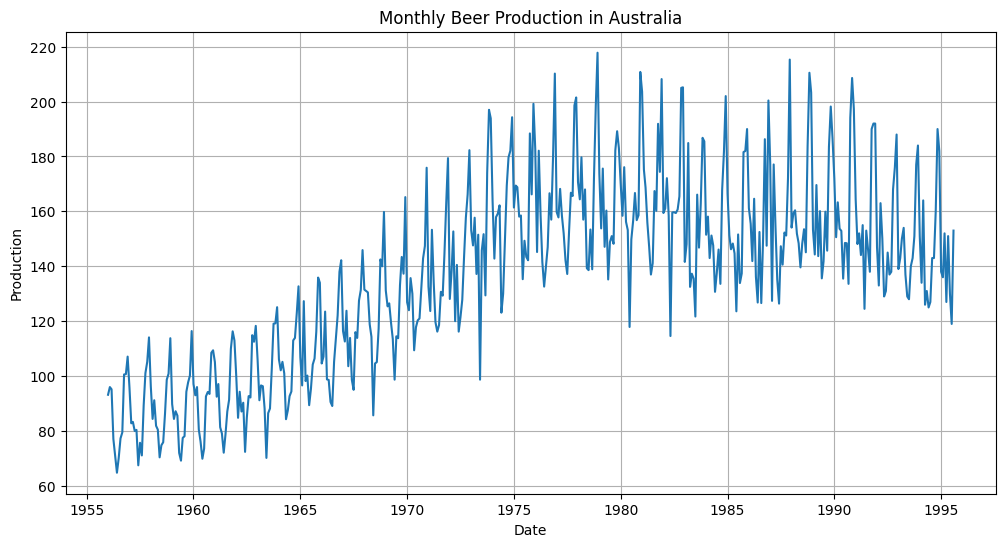

In [111]:
# Преобразование столбца Month в формат даты
data['Month'] = pd.to_datetime(data['Month'], format='%Y-%m')
data.set_index('Month', inplace=True)

# Посмотреть на данные
print(data.head())

# Визуализация исходных данных
plt.figure(figsize=(12, 6))
plt.plot(data.index, data['Monthly beer production'])
plt.title('Monthly Beer Production in Australia')
plt.xlabel('Date')
plt.ylabel('Production')
plt.grid(True)
plt.show()


Создание дополнительных признаков

In [112]:
# Создаем дополнительные признаки
data['Year'] = data.index.year
data['Month_num'] = data.index.month

# Создаем lag признаки
for lag in range(1, 13):  # Добавить лаги за последние 12 месяцев
    data[f'Lag_{lag}'] = data['Monthly beer production'].shift(lag)

# Убираем строки с пустыми значениями
data.dropna(inplace=True)


Определение признаков и разделение данных

In [113]:
# Определяем признак X и целевую переменную y
X = data.drop(columns='Monthly beer production')
y = data['Monthly beer production']

# Разделение на обучающую и тестовую выборки
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

print("Training data shape:", X_train.shape)
print("Testing data shape:", X_test.shape)


Training data shape: (371, 14)
Testing data shape: (93, 14)


Модель Random Forest

Normalized RMSE (Random Forest): 0.11110926083312316


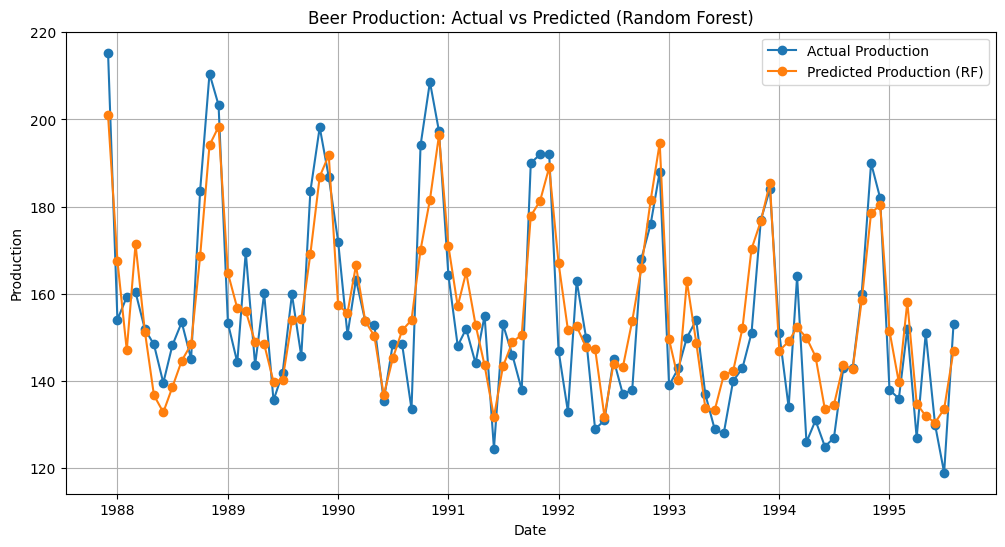

In [114]:
from sklearn.ensemble import RandomForestRegressor

model = RandomForestRegressor(n_estimators=200, max_depth=10, min_samples_split=5, random_state=42)
model.fit(X_train, y_train)

y_pred_rf = model.predict(X_test)
# Оценка производительности
nrmse = np.sqrt(mean_squared_error(y_test, y_pred_rf)) / (y_test.max() - y_test.min())
print(f'Normalized RMSE (Random Forest): {nrmse}')

# Визуализация предсказаний Random Forest
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Production', marker='o')
plt.plot(y_test.index, y_pred_rf, label='Predicted Production (RF)', marker='o')
plt.title('Beer Production: Actual vs Predicted (Random Forest)')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


Модель LSTM

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Normalized RMSE (LSTM): 0.13686551531870608


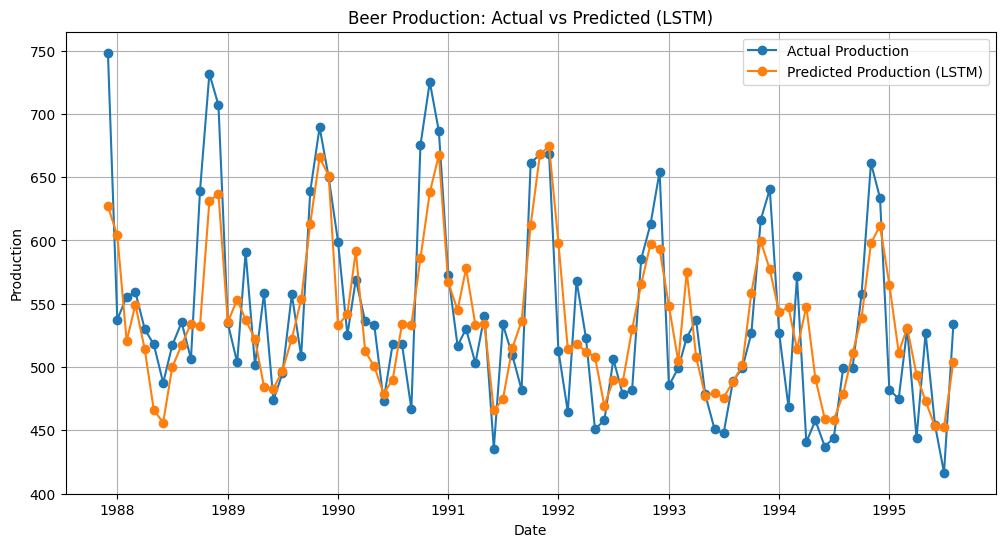

In [119]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Предполагается, что данные уже нормализованы и находятся в диапазоне [0, 1]

# #### LSTM Model ####

# Подготовка данных для LSTM
X_train_lstm = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_lstm = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Создание модели LSTM
lstm_model = Sequential()
lstm_model.add(LSTM(50, activation='relu', return_sequences=False, input_shape=(X_train_lstm.shape[1], 1)))
lstm_model.add(Dropout(0.2))
lstm_model.add(Dense(1))

# Компиляция модели
lstm_model.compile(optimizer='adam', loss='mse')

# Обучение модели LSTM
lstm_model.fit(X_train_lstm, y_train, epochs=200, verbose=0)

# Предсказания на тестовой выборке
y_pred_lstm = lstm_model.predict(X_test_lstm)

# Приведение предсказанных значений обратно к исходному масштабу, если они были нормализованы
# Если y_test был нормализован, то нужно его сделать тоже
# Предполагается, что scaler уже создан для нормализации y_train и y_test
y_pred_lstm_inverse = scaler.inverse_transform(y_pred_lstm)
y_test_inverse = scaler.inverse_transform(y_test.values.reshape(-1, 1))

# Оценка производительности LSTM с использованием NRMSE
nrmse_lstm = np.sqrt(mean_squared_error(y_test_inverse, y_pred_lstm_inverse)) / (y_test_inverse.max() - y_test_inverse.min())
print(f'Normalized RMSE (LSTM): {nrmse_lstm}')

# Визуализация предсказаний LSTM
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test_inverse, label='Actual Production', marker='o')
plt.plot(y_test.index, y_pred_lstm_inverse, label='Predicted Production (LSTM)', marker='o')
plt.title('Beer Production: Actual vs Predicted (LSTM)')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


Модель SimpleRNN

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 105ms/step
Normalized RMSE (SimpleRNN): 0.35401197664366413


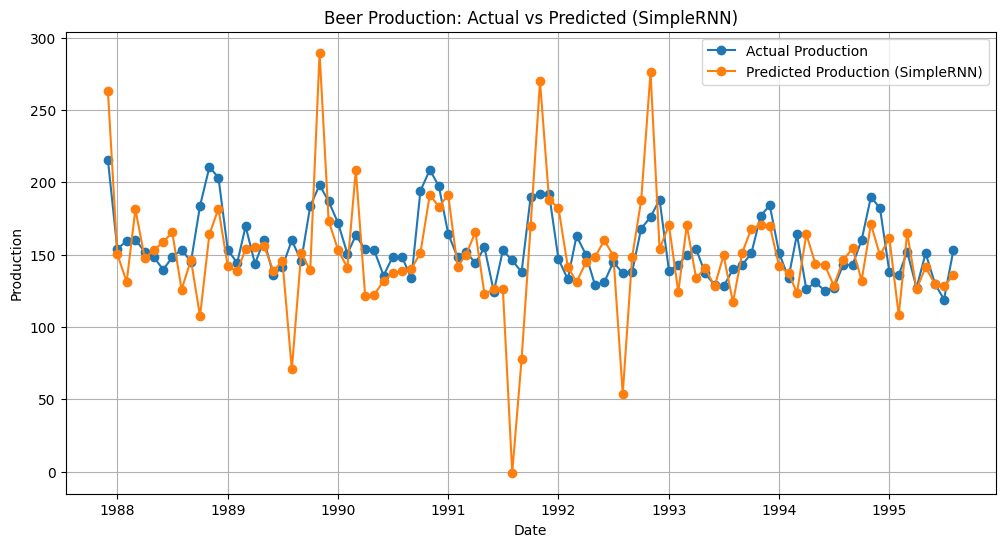

In [120]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

# Нормализация целевой переменной
scaler = MinMaxScaler(feature_range=(0, 1))
y_train_scaled = scaler.fit_transform(y_train.values.reshape(-1, 1))
y_test_scaled = scaler.transform(y_test.values.reshape(-1, 1))

# #### SimpleRNN Model ####

# Подготовка данных для SimpleRNN
X_train_rnn = X_train.values.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test_rnn = X_test.values.reshape((X_test.shape[0], X_test.shape[1], 1))

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN, Dense, Dropout

# Создание модели SimpleRNN
simple_rnn_model = Sequential()
simple_rnn_model.add(SimpleRNN(50, activation='relu', return_sequences=False, input_shape=(X_train_rnn.shape[1], 1)))
simple_rnn_model.add(Dropout(0.2))
simple_rnn_model.add(Dense(1))

# Компиляция модели
simple_rnn_model.compile(optimizer='adam', loss='mse')

# Обучение модели SimpleRNN
simple_rnn_model.fit(X_train_rnn, y_train_scaled, epochs=100, verbose=0)

# Предсказания на тестовой выборке
y_pred_simple_rnn_scaled = simple_rnn_model.predict(X_test_rnn)

# Оценка производительности SimpleRNN с использованием NRMSE
nrmse_simple_rnn = np.sqrt(mean_squared_error(y_test_scaled, y_pred_simple_rnn_scaled)) / (y_test_scaled.max() - y_test_scaled.min())
print(f'Normalized RMSE (SimpleRNN): {nrmse_simple_rnn}')

# Инверсная трансформация для визуализации и оценки
y_pred_simple_rnn_inverse = scaler.inverse_transform(y_pred_simple_rnn_scaled)
y_test_inverse = scaler.inverse_transform(y_test_scaled)

# Визуализация предсказаний SimpleRNN
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test_inverse, label='Actual Production', marker='o')
plt.plot(y_test.index, y_pred_simple_rnn_inverse, label='Predicted Production (SimpleRNN)', marker='o')
plt.title('Beer Production: Actual vs Predicted (SimpleRNN)')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()


Интервальное прогнозирование

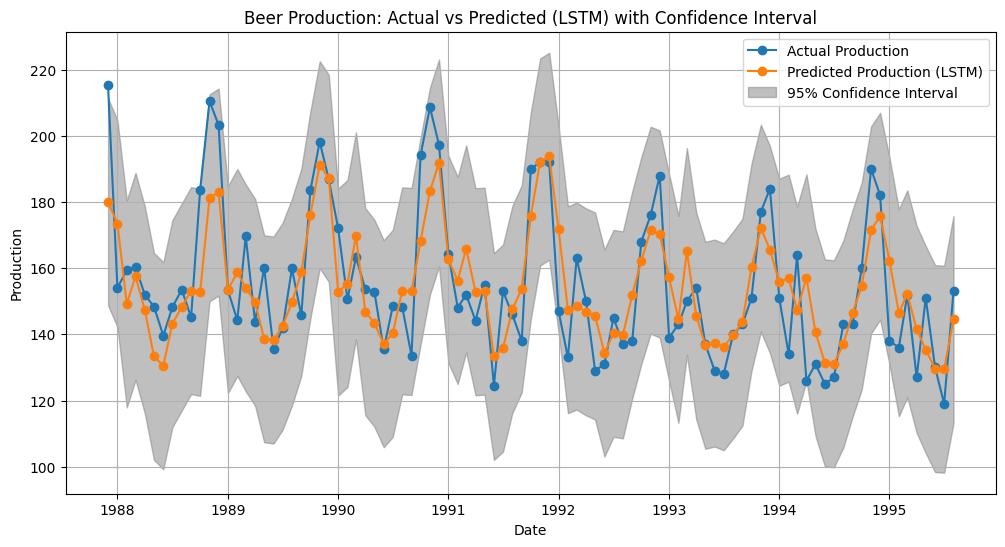

In [121]:
# #### Интервальное прогнозирование ####
# Простой метод для определения доверительных интервалов
y_pred_mean = np.mean(y_pred_lstm)
y_pred_std = np.std(y_pred_lstm)

lower_bound = y_pred_lstm - 1.96 * y_pred_std
upper_bound = y_pred_lstm + 1.96 * y_pred_std

# Визуализация с доверительными интервалами
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test, label='Actual Production', marker='o')
plt.plot(y_test.index, y_pred_lstm, label='Predicted Production (LSTM)', marker='o')
plt.fill_between(y_test.index, lower_bound.flatten(), upper_bound.flatten(), color='gray', alpha=0.5, label='95% Confidence Interval')
plt.title('Beer Production: Actual vs Predicted (LSTM) with Confidence Interval')
plt.xlabel('Date')
plt.ylabel('Production')
plt.legend()
plt.grid(True)
plt.show()
